# Actor Critic with Pytorch
### Introduction
This notebook will train a policy using the actor-critic framework, where the policy is trained usign the policy gradient algorithm (Actor) while another network will learn an estimate of the value function (critic). This framework is more sample efficient than just using Policy gradients, it's a way to merge Policy and Value based methods.
One big advangage of Actor-Critic models are the sample efficiency. Now we don't need to wait for a full eposide to start learning, we can make an update at each timestep.

### Algorithm

![alt text](imgs/actor_critic.png "Game")
The main actors are:
* Critic: Estimate how good the action taken is. (Input state, output scalar value with estimative)
* Actor: Just the policy (Input state, output distribution of actions)

#### References
* https://medium.com/@henrymao/reinforcement-learning-using-asynchronous-advantage-actor-critic-704147f91686
* https://medium.freecodecamp.org/an-intro-to-advantage-actor-critic-methods-lets-play-sonic-the-hedgehog-86d6240171d
* https://hackernoon.com/intuitive-rl-intro-to-advantage-actor-critic-a2c-4ff545978752
* https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-8-asynchronous-actor-critic-agents-a3c-c88f72a5e9f2
* https://github.com/nikhilbarhate99/Actor-Critic
* http://rail.eecs.berkeley.edu/deeprlcourse-fa17/f17docs/lecture_5_actor_critic_pdf.pdf
* https://www.youtube.com/watch?v=O5BlozCJBSE
* https://www.youtube.com/watch?v=bRfUxQs6xIM&t=28s
* https://www.youtube.com/watch?v=lvoHnicueoE&t=4s
* http://inoryy.com/post/tensorflow2-deep-reinforcement-learning/

### Import Libraries

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

### Initialize Environment and Hyperparameters

In [2]:
#env = gym.make('CartPole-v1')
# Uncomment for this environment (takes longer to train)
env = gym.make('LunarLander-v2')
env.seed(1)
torch.manual_seed(1)

# Hyperparameters
learning_rate = 0.01
gamma = 0.99
num_episodes=3000
render = False

print('Amount of rewards consider as win:', env.spec.reward_threshold)
print('Action space:', env.action_space.n)
print('Observation space:', env.observation_space.shape)
print('Reward range:', env.reward_range)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Amount of rewards consider as win: 200
Action space: 4
Observation space: (8,)
Reward range: (-inf, inf)


/Users/leonardo_a/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### Define the Actor/Critic Model

In [3]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        state_space = env.observation_space.shape[0]
        action_space = env.action_space.n
        num_hidden = 128
        
        self.affine = nn.Linear(state_space, num_hidden, bias=False)
        
        # Action and value head
        self.action_layer = nn.Linear(num_hidden, action_space, bias=False)
        self.value_layer = nn.Linear(num_hidden, 1, bias=False)
        
        self.logprobs = []
        self.state_values = []
        self.rewards = []
        # Store sum of rewards from each episode
        self.reward_history = []

    def forward(self, state):
        state = torch.from_numpy(state).float()
        state = F.relu(self.affine(state))
        
        state_value = self.value_layer(state)
        
        # Sample policy action space
        action_probs = F.softmax(self.action_layer(state), dim=-1)
        action_distribution = Categorical(action_probs)
        action = action_distribution.sample()
        
        self.logprobs.append(action_distribution.log_prob(action))
        self.state_values.append(state_value)
        
        return action.item()
    
    def calculateLoss(self, gamma=0.99):
        
        # calculating discounted rewards:
        rewards = []
        dis_reward = 0
        for reward in self.rewards[::-1]:
            dis_reward = reward + gamma * dis_reward
            rewards.insert(0, dis_reward)
        
        # Append total rewards on the episode
        self.reward_history.append(np.sum(self.rewards))
                
        # normalizing the rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std())
        
        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        return loss
    
    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]

### Initialize Network and Optimizer

In [4]:
policy = ActorCritic()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

### Train on the Environment

In [5]:
running_reward = 0
for episode in range(num_episodes):
    state = env.reset()
    for time in range(1000):
        action = policy(state)
        state, reward, done, _ = env.step(action)
        policy.rewards.append(reward)
        running_reward += reward
        if done:
            break

    # Updating the policy :
    optimizer.zero_grad()
    loss = policy.calculateLoss(gamma)
    loss.backward()
    optimizer.step()        
    policy.clearMemory()

    if (running_reward/time) > env.spec.reward_threshold:
        print("########## Solved! ##########")
        break

    if episode % 50 == 0:
        rewards_per_time = running_reward/time
        print('Episode {}\tlength: {}\treward: {}\trun_reward: {}'.format(
            episode, time, rewards_per_time, running_reward))
        running_reward = 0

Episode 0	length: 62	reward: -2.84031124625867	run_reward: -176.09929726803756
Episode 50	length: 112	reward: -85.49574132201509	run_reward: -9575.52302806569
Episode 100	length: 120	reward: -79.0902378790945	run_reward: -9490.82854549134
Episode 150	length: 213	reward: -27.25797408805849	run_reward: -5805.948480756459
Episode 200	length: 999	reward: -2.8527003084907	run_reward: -2849.8476081822096
Episode 250	length: 999	reward: -0.10324483897538808	run_reward: -103.14159413641269
Episode 300	length: 999	reward: 0.4311290567680618	run_reward: 430.69792771129374
Episode 350	length: 999	reward: 1.043586378764428	run_reward: 1042.5427923856635
Episode 400	length: 999	reward: 2.639597943249494	run_reward: 2636.958345306244
Episode 450	length: 999	reward: 3.919685321586311	run_reward: 3915.765636264725
Episode 500	length: 999	reward: 4.2923414928142325	run_reward: 4288.049151321418
Episode 550	length: 258	reward: 25.57322649178646	run_reward: 6597.892434880907
Episode 600	length: 388	rewar

### Plot Training information

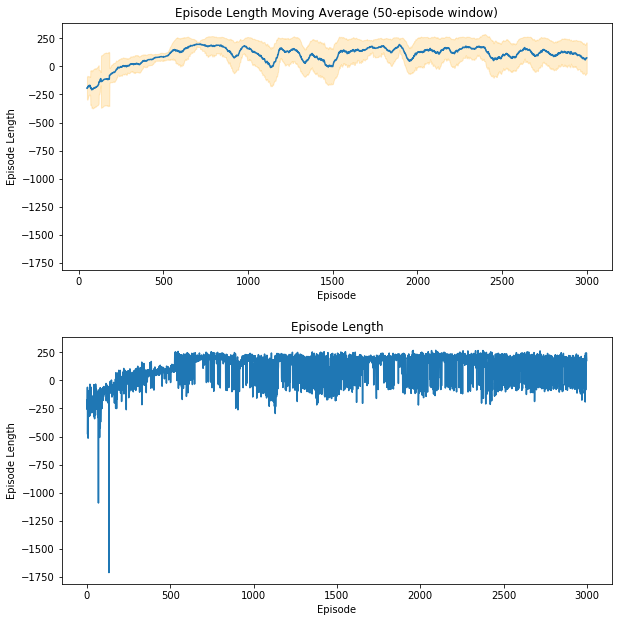

In [6]:
# number of episodes for rolling average
window = 50

# Create grid 2x1 plots
fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9, 9])

# Calculate the mean of the rewards over time
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
# Calculate the standard deviation over time
std = pd.Series(policy.reward_history).rolling(window).std()

# Plot graph 1
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)), rolling_mean -
                 std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title(
    'Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode Length')

# Plot graph 2
ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()

### Test the Trained Policy

In [7]:
state = env.reset()

for time in range(1000):
    action = policy(state)

    # Uncomment to render the visual state in a window
    env.render()

    # Step through environment using chosen action
    state, reward, done, _ = env.step(action)
    if done:
        break